In [220]:
# Problem setup

# image size
# H, W = 50505, 50505
H, W = 10000, 10000

bg_ratio_base = 0.8
bg_ratios = bg_ratio_base  # +np.random.rand() * (1-bg_ratio_base)

# cats = ["hello", "world", "foo", "bar", "baz", "qux"]
cats = [ "Normal Glomerulus", "IFTA", "Renal Vessels"]

C = len(cats)

In [221]:
# Program setup
import numpy as np

# patch size
# h, w = 512, 512
# h, w = 224, 224
h, w = 4096, 4096

# tile size
# Ht, Wt = 1000, 1000
Ht, Wt = 1000, 1000


exclude_bg = False
power = 1.2
temperature = 1  # A temperature less than 1 will sharpen the distribution

# data types (memory concerns)
dtype_index = np.int8  # need to be able to store -1
dtype_count = np.uint32  # need to be able to store global counts
dtype_score = np.float64  # need to be able to work with global normalization and precision to satisfy "sum to 1" https://stackoverflow.com/a/46539921 subject to tolerance 1e-8 https://github.com/numpy/numpy/blob/c2b6ab9924271b96d3c783f7818723a1bb8f511a/numpy/random/mtrand/mtrand.pyx#L1093C46-L1093C50, and be careful with precision underflow

# -- V
# plot resize size
Hp, Wp = 512, 512
# image and plot data types
dtype_value = np.float16  # need to be able to store original signal (image)
dtype_plot = np.float32  # normalize for dtype_value, required for imshow

In [222]:
# Sampling Program setup
import numpy as np

N = 10000  # Number of samples
size_variation_range = 0.1  # ±10% size variation
rotation_range = 2 * np.pi  # 0-360° rotation variation

In [223]:
# -- D
# import numpy as np
# from skimage.transform import rescale, resize, downscale_local_mean

# mask = np.zeros((H, W), dtype=dtype_index)
# %timeit rescale(mask, (1/Ht, 1/Wt), order=0, anti_aliasing=False).shape  # 62 ms ± 2.73 ms
# %timeit resize(mask, (H//Ht, W//Wt), order=0, anti_aliasing=False).shape  # 61.8 ms ± 2.08 ms
# %timeit downscale_local_mean(mask, (Ht, Wt)).shape  # 1.5 s ± 11.5 ms

# mask_oh = np.zeros((H, W, C), dtype=dtype_index)
# %timeit rescale(mask_oh, (1/Ht, 1/Wt, 1), order=0, anti_aliasing=False).shape  # 520 ms ± 6.19 ms
# %timeit resize(mask_oh, (H//Ht, W//Wt), order=0, anti_aliasing=False).shape  # 528 ms ± 11.1 ms
# %timeit downscale_local_mean(mask_oh, (Ht, Wt, C)).shape  # 9.56 s ± 60.7 ms

# count = np.zeros((H, W, C), dtype=dtype_count)
# %timeit rescale(count, (1/Ht, 1/Wt, 1), order=0, anti_aliasing=False).shape  # 23.1 s ± 433 ms
# %timeit resize(count, (H//Ht, W//Wt), order=0, anti_aliasing=False).shape  # 23 s ± 494 ms
# %timeit downscale_local_mean(count, (Ht, Wt, C)).shape  # 3.1 s ± 382 ms

# score = np.zeros((H, W), dtype=dtype_score)
# %timeit rescale(score, (1/Ht, 1/Wt), order=0, anti_aliasing=False).shape  # 706 ms ± 32.4
# %timeit resize(score, (H//Ht, W//Wt), order=0, anti_aliasing=False).shape  # 685 ms ± 16.7 ms
# %timeit downscale_local_mean(score, (Ht, Wt)).shape  # 8.55 s ± 302 ms

# channel = np.zeros((H, W), dtype=dtype_value)
# %timeit rescale(channel, (1/Ht, 1/Wt), order=0, anti_aliasing=False).shape  # 4.37 s ± 76.4 ms
# %timeit resize(channel, (H//Ht, W//Wt), order=0, anti_aliasing=False).shape  # 4.51 s ± 77.4 ms
# %timeit downscale_local_mean(channel, (Ht, Wt)).shape  # 4.25 s ± 15.7 ms

# image = np.zeros((H, W, 3), dtype=dtype_value)
# %timeit rescale(image, (1/Ht, 1/Wt, 1), order=0, anti_aliasing=False).shape  # 22.7 s ± 166 ms
# %timeit resize(image, (H//Ht, W//Wt), order=0, anti_aliasing=False).shape  # 22.8 s ± 178 ms
# %timeit downscale_local_mean(image, (Ht, Wt, 3)).shape  # 13.2 s ± 141 ms

In [224]:
from skimage.transform import resize
import matplotlib.pyplot as plt


def ecoimshow(image, ax=None, dtype=None, Hp=Hp, Wp=Wp, axis_off=True, aspect_equal=True, **kwargs):
    if ax is None:
        ax = plt.gca()
    if dtype is not None:
        image = image.astype(dtype)
    rH, rW = image.shape[:2] / np.array([Hp, Wp])
    if rH > rW:
        Hp_ = Hp
        Wp_ = int(Wp * rH / rW)
    else:
        Hp_ = int(Hp * rW / rH)
        Wp_ = Wp
    image = resize(image, (Hp_, Wp_), order=0, anti_aliasing=False)
    default_kwargs = dict(interpolation='nearest')
    default_kwargs.update(kwargs)
    handle = ax.imshow(image, **default_kwargs)
    if axis_off:
        ax.axis('off')
    if aspect_equal:
        ax.set_aspect('equal')
    return handle

In [225]:
# Generate masks information for each category
import numpy as np

cat_ratios = np.random.dirichlet(np.ones(C)).astype(dtype_score) * (1 - bg_ratios)
print(cat_ratios, cat_ratios.sum())

# -- V
cat2id = {cat: i + 1 for i, cat in enumerate(cats)}
cat_colors = np.random.rand(C, 3).tolist()

[0.10051143 0.01968085 0.00754408 0.00487671 0.06067893 0.006708  ] 0.19999999999999996


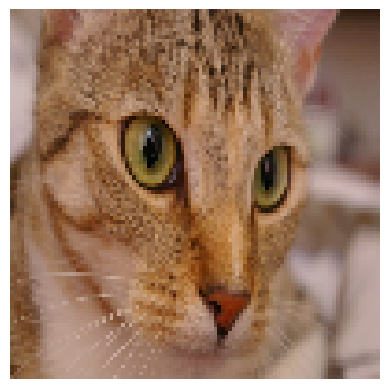

In [226]:
# %%prun
# Generate image
# NB: can be skipped safely

# -- V
from skimage import data
from skimage.transform import resize

image = data.cat().astype(dtype_value) / 255
mosaic = np.array((100, 100))  # for textual in debug
image = resize(image, (H, W) / mosaic, order=0, anti_aliasing=False)
image = resize(image, (H, W), order=0, anti_aliasing=False)
ecoimshow(image)

In [227]:
# Generate masks
import numpy as np
from skimage import draw

mask_ells = {}

for cat, ratio in sorted(zip(cats, cat_ratios), key=lambda x: -x[1]):
    # print(cat, ratio)
    mask_ells[cat] = []
    regions = np.random.randint(1, 10)
    for _ in range(regions):
        # generate a region for this category, expecting to match the ratio
        # of the category
        x = np.random.randint(0, W)
        y = np.random.randint(0, H)
        # area = pi * h * w = H * W * ratio / regions
        ell_hw = H * W * ratio / regions / np.pi
        mu, sigma = 0.5, 0.02
        ell_h = ell_hw ** np.random.normal(mu, sigma)
        ell_w = ell_hw / ell_h
        rot = np.random.rand() * np.pi
        # print(x, y, h, w, rot)
        mask_ells[cat].append((x, y, ell_h, ell_w, rot))

mask = np.zeros((H, W), dtype=dtype_index)

for cat, ells_ in mask_ells.items():
    for x, y, ell_h, ell_w, rot in ells_:
        rr, cc = draw.ellipse(y, x, ell_h, ell_w, rotation=rot, shape=(H, W))
        mask[rr, cc] = cat2id[cat]

print("Mask stats:", mask.min(), mask.max(), mask.mean(), mask.std())

Mask stats: 0 6 0.46543823 1.2940456499113344


In [228]:
# # -- D

# # np.save("mask.npy", mask)
# mask = np.load("mask.npy")

In [229]:
# Mask API to make sure the flexibility of the mask data structure
# Could even be dynamical

# retrieve from real mask
# 01:03, 40.81it/s
# a lot of memory
def get_tile_mask_real(row, row_end, col, col_end):
    tile_mask = mask[row:row_end, col:col_end]
    return tile_mask

# retrieve from generative mask
# 01:15, 34.37it/s
# cool but a bit slow
def get_tile_mask_gen(row, row_end, col, col_end):
    tile_mask = np.zeros((row_end-row, col_end-col), dtype=dtype_index)
    for cat, ells_ in mask_ells.items():
        for x, y, ell_h, ell_w, rot in ells_:
            x, y = x - col, y - row
            rr, cc = draw.ellipse(y, x, ell_h, ell_w, rotation=rot, shape=(row_end-row, col_end-col))
            tile_mask[rr, cc] = cat2id[cat]
    return tile_mask

# retrieve from abstract mask
# 16:16, 2.66it/s
# painfully slow, and prone to errors ( in ellipse calculation )
def get_tile_mask_abs(row, row_end, col, col_end):
    tile_mask = np.zeros((row_end-row, col_end-col), dtype=dtype_index)
    rr, cc = np.meshgrid(np.arange(row, row_end), np.arange(col, col_end), indexing='ij')
    for cat, ells_ in mask_ells.items():
        for x, y, ell_h, ell_w, rot in ells_:
            x, y = x - col, y - row
            mask = ((cc-x) * np.cos(rot) + (rr-y) * np.sin(rot)) ** 2 / ell_w ** 2 + ((cc-x) * np.sin(rot) - (rr-y) * np.cos(rot)) ** 2 / ell_h ** 2 <= 1
            tile_mask[mask] = cat2id[cat]

    return tile_mask

get_tile_mask = get_tile_mask_gen

# you can delete the mask to free memory if not using the real one and not going to visualize it
# del mask

[<BarContainer object of 7 artists>]

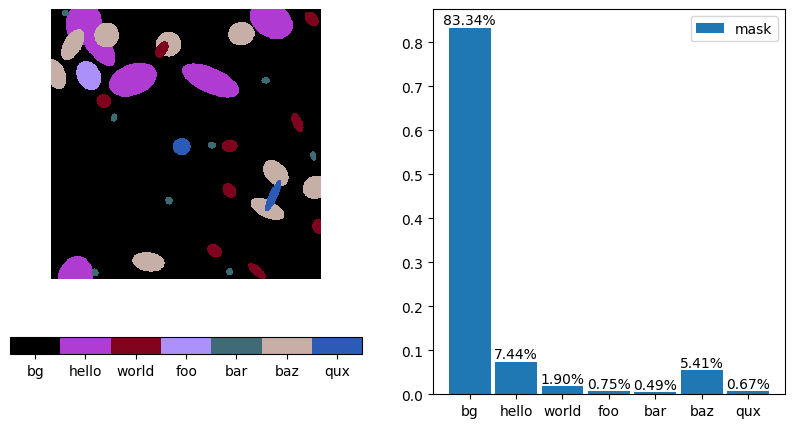

In [230]:
# %%prun
# -- V
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np


def multiple_bar_chart(series, ax=None, margin=0.1, text_format="{:}", ticks=None):
    if ax is None:
        ax = plt.gca()

    bar_width = (1 - margin) / len(series)
    series_len = max(map(len, series.values()))

    labels, series_data = zip(*series.items())  # to maintain the order
    bars = []
    for i, bar_data in enumerate(series_data):
        bar = ax.bar(np.arange(series_len) + i * bar_width, bar_data, width=bar_width)
        for j, data in enumerate(bar_data):
            ax.text(
                j + i * bar_width,
                data,
                text_format.format(data),
                ha="center",
                va="bottom",
            )
        bars.append(bar)
    ax.legend(labels)
    if ticks is not None:
        ax.set_xticks(np.arange(series_len) + (1 - margin - bar_width) / 2, ticks)
    return bars


bg_cmap = ListedColormap([[0, 0, 0]] + cat_colors)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
mask_im = ecoimshow(mask, ax=axs[0], cmap=bg_cmap)
# Add color bar
mask_cbar = fig.colorbar(mask_im, ax=axs[0], location="bottom")
mask_cbar.set_ticks((np.arange(C + 1) + 0.5) * C / (C + 1), labels=["bg"] + cats)

counts, _ = np.histogram(mask, bins=C + 1, range=(0, C + 1))
multiple_bar_chart(
    {"mask": counts / counts.sum()},
    ax=axs[1],
    text_format="{:.2%}",
    ticks=["bg"] + cats,
)

In [231]:
# # -- D

# import numpy as np

# global_category_frequency = np.empty(C + 1, dtype=dtype_score)
# for i in range(C + 1):
#     global_category_frequency[i] = np.sum(mask == i) / (H * W)

# category_weights = 1 / global_category_frequency
# category_weights /= category_weights.sum()

# print(global_category_frequency)
# print(category_weights)

In [232]:
from itertools import product
import numpy as np
from tqdm import tqdm

global_category_count = np.zeros(C + 1, dtype=dtype_count)
category_target = np.arange(C + 1)


def collect_category_count(row, col):
    row_end = min(row + Ht, H)
    col_end = min(col + Wt, W)
    tile_mask = get_tile_mask(row, row_end, col, col_end)
    tile_category_count = np.sum(
        tile_mask.reshape(-1, 1) == category_target, axis=0, dtype=dtype_count
    )
    return tile_category_count


for row, col in tqdm(list(product(range(0, H, Ht), range(0, W, Wt)))):
    global_category_count += collect_category_count(row, col)
global_category_frequency = global_category_count.astype(dtype_score) / (H * W)

category_weights = 1 / global_category_frequency
category_weights /= category_weights.sum()

print(global_category_frequency)
print(category_weights)

100%|██████████| 100/100 [00:03<00:00, 33.03it/s]

[0.83336857 0.07436064 0.01900664 0.00754415 0.00487594 0.05413626
 0.0067078 ]
[0.00209615 0.02349176 0.09190801 0.23155193 0.35826169 0.03226788
 0.26042257]


In [233]:
# Prepare tiles
import numpy as np

h_half, w_half = h // 2, w // 2
Hx, Wx = H + h, W + w
Htx, Wtx = Ht + h, Wt + w

# eXtented mask
# maskx = np.empty((Hx, Wx), dtype=dtype_index)
# maskx.fill(-1)

# maskx[h_half:-h_half, w_half:-w_half] = mask  # memory copy
# def get_tile_maskx(rowx, rowx_end, colx, colx_end):
#     tile_maskx = maskx[rowx:rowx_end, colx:colx_end]
#     return tile_maskx


def get_tile_maskx(rowx, rowx_end, colx, colx_end):
    # TODO: not sure if reusing the memory saves time
    Htx_, Wtx_ = rowx_end - rowx, colx_end - colx
    tile_maskx = np.empty((Htx_, Wtx_), dtype=dtype_index)
    tile_maskx.fill(-1)

    rowx_on_mask = rowx - h_half
    rowx_end_on_mask = rowx_end - h_half
    colx_on_mask = colx - w_half
    colx_end_on_mask = colx_end - w_half

    rowt, colt, rowt_end, colt_end = 0, 0, Htx_, Wtx_

    # executive rows and columns are within the image
    if rowx_on_mask < 0:
        rowx_on_mask = 0
        rowx_ = rowx_on_mask + h_half
        rowt += rowx_ - rowx
    if rowx_end_on_mask > H:
        rowx_end_on_mask = H
        rowx_end_ = rowx_end_on_mask + h_half
        rowt_end += rowx_end_ - rowx_end
    if colx_on_mask < 0:
        colx_on_mask = 0
        colx_ = colx_on_mask + w_half
        colt += colx_ - colx
    if colx_end_on_mask > W:
        colx_end_on_mask = W
        colx_end_ = colx_end_on_mask + w_half
        colt_end += colx_end_ - colx_end

    # print(">", rowx, rowx_end, colx, colx_end)  # -- d
    # print(">", rowx_on_mask, rowx_end_on_mask, colx_on_mask, colx_end_on_mask)  # -- d
    # print(">", rowt, rowt_end, colt, colt_end)  # -- d

    tile_maskx[rowt:rowt_end, colt:colt_end] = get_tile_mask(
        rowx_on_mask, rowx_end_on_mask, colx_on_mask, colx_end_on_mask
    )
    return tile_maskx

# TODO: use retriever functions and lrucache
# ground rows, indexed by row number
ground_rowx = {}
# ground columns, indexed by column number
ground_colx = {}

In [234]:
def one_hot(a, num_classes=None, dtype=dtype_index):
    if num_classes is None:
        num_classes = np.max(a) + 1  # handle 0
    # print(a.min(), a.max())
    # return np.eye(num_classes, dtype=dtype)[a.reshape(-1)].reshape(*a.shape, -1)
    # handle -1
    # it can be intepreted as the last index
    # add a redundant class in the end and remove the column
    index_matrix = np.eye(num_classes + 1, dtype=dtype)[:, :-1]
    return index_matrix[a.ravel()].reshape(*a.shape, -1)


def get_tile_cdix(rowx, colx):
    # get the cumulative difference image (CDI) for the tile with extension margin
    # given the context, the coordinates may never be out of bounds
    # we still need to examine the boundary conditions for the last rows and cols
    # noted the margin has fixed size but the tile size may vary
    rowx_end = min(rowx + Ht + h, Hx)
    colx_end = min(colx + Wt + w, Wx)
    # tile_maskx = get_tile_maskx(rowx, rowx_end, colx, colx_end)
    tile_maskx = get_tile_maskx(rowx, rowx_end, colx, colx_end)
    # print(tile_maskx)
    # print(tile_maskx_x)
    # ecoimshow(tile_maskx, plt.subplot())
    # ecoimshow(tile_maskx_x, plt.subplot())
    # assert np.all(tile_maskx_x == tile_maskx)
    tile_maskx_oh = one_hot(tile_maskx, C + 1)
    # cumsum first so that the shape is preserved
    tile_cdix = tile_maskx_oh.cumsum(axis=0, dtype=dtype_count).cumsum(
        axis=1, dtype=dtype_count
    )
    tile_cdix += ground_rowx.get((rowx, colx), 0)
    tile_cdix += ground_colx.get((rowx, colx), 0)

    # update the ground rows and columns for the next tiles
    ground_rowx[rowx_end - h, colx] = tile_cdix[[-h], :]
    ground_colx[rowx, colx_end - w] = tile_cdix[:, [-w]]

    return tile_cdix


def get_tile_count(cdi_tx):
    # noted the margin has fixed size but the tile size may vary
    tile_cdi_top_left = cdi_tx[:-h, :-w]
    tile_cdi_top_right = cdi_tx[:-h, w:]
    tile_cdi_bottom_left = cdi_tx[h:, :-w]
    tile_cdi_bottom_right = cdi_tx[h:, w:]

    # The magic happens here: Full CDI sum centered at the windows
    tile_count = (
        tile_cdi_bottom_right
        - tile_cdi_bottom_left
        - tile_cdi_top_right
        + tile_cdi_top_left
    )
    return tile_count


def get_tile_score(tile_count, area_count, exclude_bg=False, power=1):
    tile_proportions = tile_count.astype(dtype_score) / area_count

    if exclude_bg:
        calc_pr = tile_proportions[:, :, 1:]
        calc_wt = category_weights[1:]
    else:
        calc_pr = tile_proportions
        calc_wt = category_weights

    # Power to exaggerate the differences
    if power != 1:
        calc_wt = calc_wt**power
        calc_wt /= calc_wt.sum()  # Normalize category-wise

    # Do not scale local category proportions. It just tells us the local distribution.

    # Weighting the local category proportions and summing them up to get the map
    # Score is the unnormalized probability
    tile_score = calc_pr @ calc_wt

    # NB: temperature is not applied here as it is not normalized
    return tile_score


def get_area(rowx, colx, Htx_, Wtx_):
    area_index = get_tile_maskx(rowx, rowx + Htx_, colx, colx + Wtx_) >= 0
    area_cdix = area_index.cumsum(axis=0, dtype=dtype_count).cumsum(
        axis=1, dtype=dtype_count
    )
    area_count = get_tile_count(area_cdix)
    return area_count[:, :, np.newaxis]


# NB: wrap the process_tile function to keep a clean namespace
def process_tile_score(row, col, update_ground=True):
    # print(row, col)
    # NB: the tricky coordinate transformation:
    # rowx_on_mask = row - h_half, rowx = rowx_on_mask + h_half = row
    rowx = row
    colx = col

    tile_cdix = get_tile_cdix(rowx, colx)
    Htx_, Wtx_ = tile_cdix.shape[:2]
    if update_ground:
        # update the ground rows and columns for the future tiles
        ground_rowx[rowx + Htx_ - h, colx] = tile_cdix[[-h], :]
        ground_colx[rowx, colx + Wtx_ - w] = tile_cdix[:, [-w]]

    tile_count = get_tile_count(tile_cdix)
    area_count = get_area(rowx, colx, Htx_, Wtx_)
    tile_score = get_tile_score(
        tile_count, area_count, exclude_bg=exclude_bg, power=power
    )

    return tile_score

In [235]:
from itertools import product
import numpy as np
from tqdm import tqdm


# score = np.zeros((H, W), dtype=dtype_score)
# sum of the scores for normalization
Hs, Ws = np.ceil([H / Ht, W / Wt]).astype(int)
score_map = np.empty((Hs, Ws), dtype=dtype_score)


def collect_score_sum(row, col):
    tile_score = process_tile_score(row, col)
    # Ht_, Wt_ = tile_score.shape[:2]
    # score[row:row + Ht_, col:col + Wt_] = tile_score
    score_map[row // Ht, col // Wt] = tile_score.sum()


# requires synchronization for the ground rows and columns
for row, col in tqdm(list(product(range(0, H, Ht), range(0, W, Wt)))):
    collect_score_sum(row, col)

probability_map = score_map / score_map.sum()

# Global temperature scaling
# TODO: How to tile this?
# if temperature != 1:
#     non_zero = probability_sum_map > 0
#     probability_sum_map[non_zero] = np.exp(np.log(probability_sum_map[non_zero]) / temperature)
#     probability_sum_map = probability_sum_map / probability_sum_map.sum()  # Normalize globally

probability_map.min(), probability_map.max()
print("Probability map stats:", probability_map.min(), probability_map.max(), probability_map.mean(), probability_map.std())

100%|██████████| 100/100 [00:14<00:00,  7.01it/s]

Probability map stats: 0.0008280212998326086 0.1611231435257658 0.009999999999999998 0.018580663005655307


In [236]:
# # -- D
# from itertools import product

# from tqdm import tqdm
# import numpy as np


# count_golden = np.load("window_sums.npy")

# def evaluate_tile_count(row, col):
#     # print(row, col)
#     # NB: the tricky coordinate transformation:
#     # rowx_on_mask = row - h_half, rowx = rowx_on_mask + h_half = row
#     rowx = row
#     colx = col
#     tile_cdix = get_tile_cdix(rowx, colx)
#     tile_count = get_tile_count(tile_cdix)
#     Ht_, Wt_ = tile_count.shape[:2]
#     tile_count_golden = count_golden[row:row + Ht_, col:col + Wt_]
#     assert np.all(tile_count == tile_count_golden)

# for row, col in tqdm(list(product(range(0, H, Ht), range(0, W, Wt)))):
#     evaluate_tile_count(row, col)

# del count_golden  # free memory

In [237]:
# # -- D
# from itertools import product

# from tqdm import tqdm
# import numpy as np


# # np.save("score.npy", score)
# score_golden = np.load("score.npy")

# def evaluate_tile_score(row, col):
#     tile_score = process_tile_score(row, col, update_ground=False)
    
#     Ht_, Wt_ = tile_score.shape[:2]
#     tile_score_golden = score_golden[row:row + Ht_, col:col + Wt_]
#     assert np.all(tile_score == tile_score_golden)

# for row, col in tqdm(list(product(range(0, H, Ht), range(0, W, Wt)))):
#     evaluate_tile_score(row, col)

# del score_golden  # free memory

In [238]:
# # -- D
# from itertools import product

# from tqdm import tqdm
# import numpy as np


# # probability_map.npy is using the old program and has issue with border
# # probability_map-v2.npy is using tile based version
# # np.save("probability_map-v2.npy", probability_map)
# probability_golden = np.load("probability_map-v2.npy")
# diff_tol = 1e-19

# def evaluate_tile_probability(row, col):
#     tile_score = process_tile_score(row, col, update_ground=False)
#     tile_probability = tile_score / tile_score.sum()
#     tile_probability *= probability_map[row // Ht, col // Wt]
#     Ht_, Wt_ = tile_probability.shape[:2]
#     tile_probability_golden = probability_golden[row:row + Ht_, col:col + Wt_]
#     diff = np.abs(tile_probability - tile_probability_golden)
#     # print(diff.min(), diff.max(), diff.mean(), diff.std())
#     # print(tile_probability_golden.min(), tile_probability_golden.max(), tile_probability_golden.mean(), tile_probability_golden.std())
#     assert np.all(diff < diff_tol), (diff.min(), diff.max(), diff.mean(), diff.std())

# for row, col in tqdm(list(product(range(0, H, Ht), range(0, W, Wt)))):
#     evaluate_tile_probability(row, col)

# del probability_golden  # free memory

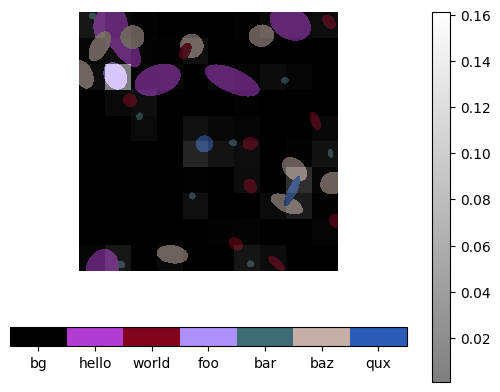

In [239]:
# -- V
H_, W_ = Hs * Ht, Ws * Ht
mask_im = ecoimshow(mask, cmap=bg_cmap, Hp=Hp * (H / H_), Wp=Wp * (W / W_))
probability_map_im = ecoimshow(probability_map, cmap="gray", alpha=0.5)

sampled_cbar = plt.colorbar(probability_map_im)
mask_cbar = plt.colorbar(mask_im, location="bottom")
mask_cbar.set_ticks((np.arange(C + 1) + 0.5) * C / (C + 1), labels=["bg"] + cats)

In [240]:
# batch sampling for N samples

import numpy as np


index = np.arange(probability_map.size)
prob = probability_map.ravel()

ys, xs = np.unravel_index(np.random.choice(index, size=N, p=prob), (Hs, Ws))
yxs = np.stack([ys, xs], axis=1)
sample_map = np.zeros_like(score_map, dtype=dtype_count)
for y, x in yxs:
    sample_map[y, x] += 1

print("Sampled Map stats:", sample_map.min(), sample_map.max(), sample_map.mean(), sample_map.std())

Sampled Map stats: 3 1590 100.0 183.85934841611945


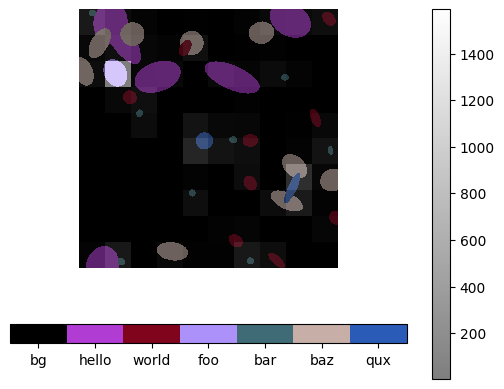

In [241]:
# -- V
mask_im = ecoimshow(mask, cmap=bg_cmap, Hp=Hp * (H / H_), Wp=Wp * (W / W_))
sample_counts_im = ecoimshow(sample_map, cmap="gray", alpha=0.5)

sampled_cbar = plt.colorbar(sample_counts_im)
mask_cbar = plt.colorbar(mask_im, location="bottom")
mask_cbar.set_ticks((np.arange(C + 1) + 0.5) * C / (C + 1), labels=["bg"] + cats)

In [242]:
# batch sampling for N samples - continued

from itertools import product

import numpy as np
from tqdm import tqdm


def sample_tile(row, col):
    tile_score = process_tile_score(row, col, update_ground=False)
    tile_probability = tile_score / tile_score.sum()

    index = np.arange(tile_probability.size)
    prob = tile_probability.ravel()
    n = sample_map[row // Ht, col // Wt]

    ys, xs = np.unravel_index(np.random.choice(index, size=n, p=prob), tile_probability.shape)
    yxs = np.stack([ys, xs], axis=1)
    yxs += [row, col]  # this is the center of the tile

    return yxs

yxs_list = []
# does not require synchronization
for row, col in tqdm(list(product(range(0, H, Ht), range(0, W, Wt)))):
    yxs_list.append(sample_tile(row, col))

yxs = np.concatenate(yxs_list, axis=0)
hws = np.random.uniform(
    (1 - size_variation_range), (1 + size_variation_range), (N, 2)
) * [h, w]
rots = np.random.uniform(-rotation_range, rotation_range, (N, 1))

# sampled_patches = np.concatenate([yxs, hws], axis=1)
sampled_patches = np.concatenate([yxs, hws, rots], axis=1)

100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


100%|██████████| 10000/10000 [01:23<00:00, 119.60it/s]


Sampled stats: 0 157 4.96238645 15.30012619983428
Sampled Category Proportions: [0.28219139 0.11440006 0.1073501  0.14918706 0.09678789 0.11567326
 0.13441024]


[<BarContainer object of 7 artists>, <BarContainer object of 7 artists>]

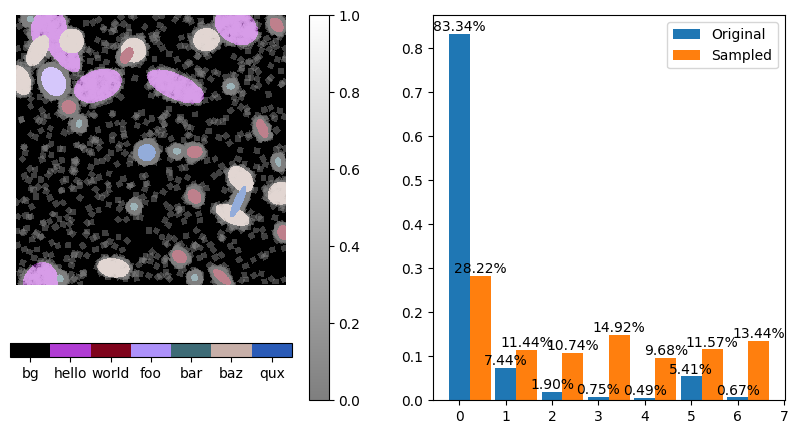

In [243]:
# -- V
# import time
# from IPython import display
from tqdm import tqdm
import numpy as np
from skimage import draw


# Verify Category Area Balance

# Get sampled count
sampled = np.zeros(mask.shape, dtype=dtype_count)
# Calculate sampled category areas
sampled_category_areas = np.zeros(C + 1, dtype=dtype_count)
category_target = np.arange(C + 1)  # dtype=mask.dtype could slow down the calculation

for y, x, hs, ws, rot in tqdm(sampled_patches):
    # v2
    # y, x = y - h_half, x - w_half
    # rr, cc = draw.rectangle((y, x), extent=(hs, ws), shape=(H, W))
    # v3: rotate the patch
    tl, tr, br, bl = (
        (-hs // 2, -ws // 2),
        (-hs // 2, ws // 2),
        (hs // 2, ws // 2),
        (hs // 2, -ws // 2),
    )
    vertices = np.array([tl, tr, br, bl]).T
    rot_mat = np.array([[np.cos(rot), -np.sin(rot)], [np.sin(rot), np.cos(rot)]])
    vertices = (rot_mat @ vertices).T
    vertices += (y, x)
    rr, cc = draw.polygon(vertices[:, 0], vertices[:, 1], shape=(H, W))

    # sampled count
    sampled[rr, cc] += 1

    # sampled category areas
    sampled_patch = mask[rr, cc]
    # row, col = y + hs // 2, x + ws // 2  # -- d
    # print(row, col)  # -- d
    # print(sampled_patch.min(), sampled_patch.max())  # -- d
    # ecoimshow(mask_colored[rr, cc])  # -- d
    # display.clear_output(wait=True)  # -- d
    # display.display(plt.gcf())  # -- d
    # time.sleep(.1)  # -- d
    sampled_category_areas += np.sum(
        sampled_patch.reshape(-1, 1) == category_target, axis=0, dtype=dtype_count
    )

print("Sampled stats:", sampled.min(), sampled.max(), sampled.mean(), sampled.std())
# Calculate area proportions
sampled_category_proportions = sampled_category_areas / sampled_category_areas.sum()
print("Sampled Category Proportions:", sampled_category_proportions)


fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sampled_level = 1 - 0.5**sampled

mask_im = ecoimshow(mask, ax=axs[0], cmap=bg_cmap)
sampled_im = ecoimshow(sampled_level, ax=axs[0], cmap="gray", alpha=0.5)

sampled_cbar = fig.colorbar(sampled_im, ax=axs[0])
mask_cbar = fig.colorbar(mask_im, ax=axs[0], location="bottom")
mask_cbar.set_ticks((np.arange(C + 1) + 0.5) * C / (C + 1), labels=["bg"] + cats)


series = {
    "Original": global_category_frequency,
    "Sampled": sampled_category_proportions,
}

multiple_bar_chart(series, ax=axs[1], margin=0.1, text_format="{:.2%}")

100%|██████████| 1000/1000 [02:47<00:00,  5.96it/s]


Sampled stats: 0 26 0.50007304 1.7450708222491051
Sampled Category Proportions: [0.27875576 0.11758972 0.09646413 0.14502803 0.112022   0.11130856
 0.1388318 ]


[<BarContainer object of 7 artists>, <BarContainer object of 7 artists>]

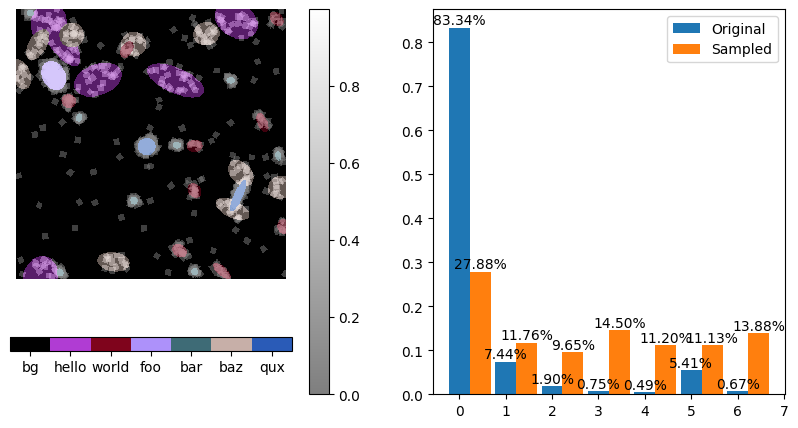

In [244]:
# single-shot sampling

import numpy as np
from tqdm import trange


def sample():
    index_map = np.arange(probability_map.size)
    prob_map = probability_map.ravel()
    i, j = np.unravel_index(np.random.choice(index_map, p=prob_map), (Hs, Ws))
    row, col = i * Ht, j * Wt

    tile_score = process_tile_score(row, col, update_ground=False)
    tile_probability = tile_score / tile_score.sum()

    index_tile = np.arange(tile_probability.size)
    prob_tile = tile_probability.ravel()
    y_, x_ = np.unravel_index(
        np.random.choice(index_tile, p=prob_tile), tile_probability.shape
    )
    y_, x_ = y_ + row, x_ + col
    h_, w_ = np.random.uniform(
        (1 - size_variation_range), (1 + size_variation_range), 2
    ) * [h, w]
    r_ = np.random.uniform(-rotation_range, rotation_range)
    # print(y_, x_, h_, w_, r_)
    return np.array((y_, x_, h_, w_, r_))


# -- V
# Get sampled count
sampled = np.zeros(mask.shape, dtype=dtype_count)
# Calculate sampled category areas
sampled_category_areas = np.zeros(C + 1, dtype=dtype_count)
category_target = np.arange(C + 1)  # dtype=mask.dtype could slow down the comparison

for _ in trange(1000):
    y, x, hs, ws, rot = sample()
    tl, tr, br, bl = (
        (-hs // 2, -ws // 2),
        (-hs // 2, ws // 2),
        (hs // 2, ws // 2),
        (hs // 2, -ws // 2),
    )
    vertices = np.array([tl, tr, br, bl]).T
    rot_mat = np.array([[np.cos(rot), -np.sin(rot)], [np.sin(rot), np.cos(rot)]])
    vertices = (rot_mat @ vertices).T
    vertices += (y, x)
    rr, cc = draw.polygon(vertices[:, 0], vertices[:, 1], shape=(H, W))

    # sampled count
    sampled[rr, cc] += 1
    # sampled category areas
    sampled_patch = mask[rr, cc]
    sampled_category_areas += np.sum(
        sampled_patch.reshape(-1, 1) == category_target, axis=0, dtype=dtype_count
    )

print("Sampled stats:", sampled.min(), sampled.max(), sampled.mean(), sampled.std())
# Calculate area proportions
sampled_category_proportions = sampled_category_areas / sampled_category_areas.sum()
print("Sampled Category Proportions:", sampled_category_proportions)


fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sampled_level = 1 - 0.5**sampled

mask_im = ecoimshow(mask, ax=axs[0], cmap=bg_cmap)
sampled_im = ecoimshow(sampled_level, ax=axs[0], cmap="gray", alpha=0.5)

sampled_cbar = fig.colorbar(sampled_im, ax=axs[0])
mask_cbar = fig.colorbar(mask_im, ax=axs[0], location="bottom")
mask_cbar.set_ticks((np.arange(C + 1) + 0.5) * C / (C + 1), labels=["bg"] + cats)


series = {
    "Original": global_category_frequency,
    "Sampled": sampled_category_proportions,
}

multiple_bar_chart(series, ax=axs[1], margin=0.1, text_format="{:.2%}")

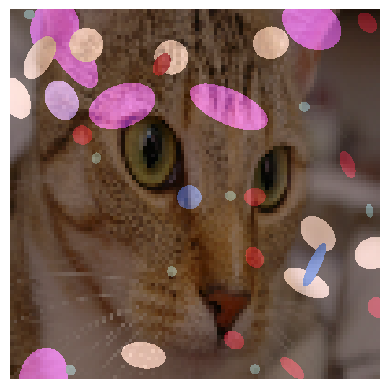

In [245]:
# -- V
# mask + image for better visualization

mask_image = image.copy()

colors = np.array([[0, 0, 0]] + cat_colors)
mask_colored = colors[mask]
mask_image += mask_colored
mask_image /= mask_image.max()

image = mask_image
ecoimshow(image)

sample: 1353.0 2271.0 238.16960286177215 233.39996649745126 -5.6523566068101605
rot in degree: -323.8561778731091


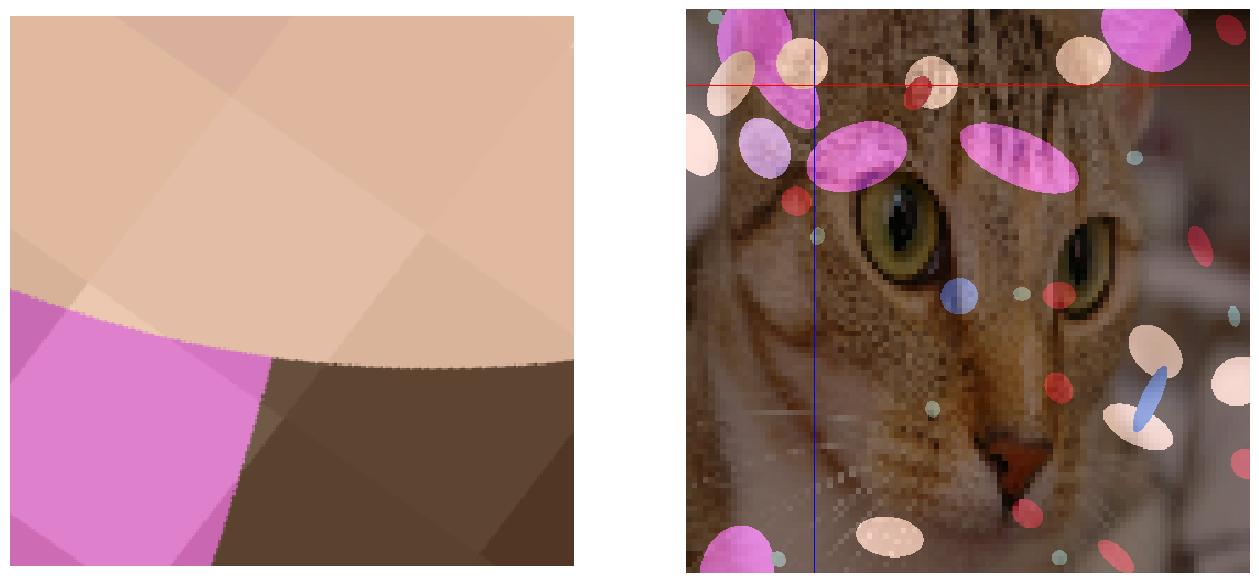

In [246]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from scipy.ndimage import map_coordinates


def get_tile_image(row, row_end, col, col_end):
    tile_image = image[row:row_end, col:col_end]
    return tile_image


def sample_patch(y, x, hs, ws, rot, order=1):
    # order 0: nearest interpolation
    # order 1: bilinear interpolation

    # generate the coordinates
    rr, cc = np.meshgrid(
        np.arange(-hs // 2, +hs // 2), np.arange(-ws // 2, +ws // 2), indexing="ij"
    )
    coords = np.stack((rr, cc), axis=0)
    # print(coords.shape)
    # print(coords[:, 0, 0], coords[:, -1, -1])
    # rotate the coordinates
    rot_mat = np.array([[np.cos(rot), -np.sin(rot)], [np.sin(rot), np.cos(rot)]])
    # einsum or tensor product: almost the same speed
    coords = np.einsum("ij,jkl->ikl", rot_mat, coords)
    # coords = np.tensordot(rot_mat, coords, axes=(1, 0))
    # shift the coordinates
    coords += np.array([y, x]).reshape(-1, 1, 1)
    # print(coords[:, 0, 0], coords[:, -1, -1], coords.shape)

    # minimal source image retrieval
    safe_margin = 5
    min_rc = np.floor(coords.min(axis=(1, 2))).astype(int) - safe_margin
    max_rc = np.ceil(coords.max(axis=(1, 2))).astype(int) + safe_margin
    # print(min_rc, max_rc)
    min_coords = coords - min_rc.reshape(-1, 1, 1)
    min_image = get_tile_image(min_rc[0], max_rc[0], min_rc[1], max_rc[1])
    # ecoimshow(min_image)
    # print(min_coords[:, 0, 0], min_coords[:, -1, -1], min_coords.shape)

    # sample patch from image of shape (H, W, 3)
    # but map_coordinates works with one channel at a time
    # patches = []
    min_patches = []
    for i in range(min_image.shape[-1]):
        # patch = map_coordinates(image[..., i], coords.reshape(2, -1), order=order)
        min_patch = map_coordinates(
            min_image[..., i], min_coords.reshape(2, -1), order=order
        )
        # print(i, np.abs(patch - min_patch).max())  # the safe margin resolves the issue
        # patch = patch.reshape(coords.shape[1:])
        min_patch = min_patch.reshape(coords.shape[1:])
        # patches.append(patch)
        min_patches.append(min_patch)
    # patch = np.stack(patches, axis=-1)
    min_patch = np.stack(min_patches, axis=-1)

    return min_patch


# -- V
y, x, hs, ws, rot = sample()
print("sample:", y, x, hs, ws, rot)
patch = sample_patch(y, x, hs, ws, rot)
print("rot in degree:", rot / np.pi * 180)
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
ecoimshow(patch, ax=axs[0])
snapshot = resize(image, (Hp, Wp), order=0, anti_aliasing=False)
# draw a cross to indicate the patch
y0, x0 = round(y * Hp / H), round(x * Wp / W)
snapshot[y0, :, :] = (1, 0, 0)
snapshot[:, x0, :] = (0, 0, 1)
ecoimshow(snapshot, ax=axs[1])